In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit import pulse, transpile, schedule
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia
import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.pulse.library import Drag

In [2]:
from qiskit.visualization import plot_histogram

In [3]:
import qiskit

### Rabi Experiment

Isidor Rabi (1898-1988) is a nobel-prize winner (1944) physicist who helped discover and develop Nuclear Magnetic Resonance (NMR). During the 1930's Rabi was one of the first scientists to investigate nuclear magnetic properties using molecular beams. A very important starting point was one of the first detections of NMR in a beam of lithium. Using molecular beams with an oscillating magnetic field, produced by an alternating current, between two static fields - as represented in the ilustration below- and a constant frequency he was able to determine the right strength in which the lithium nuclei in the beam "flipped" its spin, which means it cheanged from one of the two discret energy levels avaiable in the spin of a nuclei. Analogously the experiment that will be performed in the following code aims to determine the amplitude where the qubit goes from its ground state, $|0\rangle$, to its excited state, $|1\rangle$, by varying the amplitudes. Whereas Rabi used the spin of nuclei and varying magnetic fields, here superconducting qubits and micorwave-pulses are used. The pulses are created using Qiskit Pulse, which is better explained in the notebook "Complete_Pulse.ipynb" (https://github.com/pedr19faria/CBPF-Pulse/blob/main/Complete-Pulse%20(1).ipynb) and are a useful way to gain more control over the circuits, possibilitanting more trustworthy circuits. Determining a $\pi$ pulse, which is equivalent to a $X$ gate is extremely important, because a calibrated $\pi$ pulse possibilitates an array of other experiments, such as $T_1$ Experiment and $T_2$ with Hahn echoes, which will be done later in this notebook.

Reference: Giunta, C. J., & Mainz, V. V. (2020). Discovery of Nuclear Magnetic Resonance: Rabi, Purcell, and Bloch. In Pioneers of Magnetic Resonance (Chapter 1, pp. 3-20). ACS Symposium Series, Vol. 1349. American Chemical Society. DOI: 10.1021/bk-2020-1349.ch001

In [4]:
backend = FakeValencia()

In [5]:
backend_defaults = backend.defaults();backend_config = backend.configuration()

In [6]:
print(backend_defaults)

<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'measure', 'sx', 'rz', 'u3', 'id', 'u1', 'x', 'u2'}
  q1: {'measure', 'sx', 'rz', 'u3', 'id', 'u1', 'x', 'u2'}
  q2: {'measure', 'sx', 'rz', 'u3', 'id', 'u1', 'x', 'u2'}
  q3: {'measure', 'sx', 'rz', 'u3', 'id', 'u1', 'x', 'u2'}
  q4: {'measure', 'sx', 'rz', 'u3', 'id', 'u1', 'x', 'u2'}
Multi qubit instructions:
  (0, 1): {'cx'}
  (1, 0): {'cx'}
  (1, 2): {'cx'}
  (1, 3): {'cx'}
  (2, 1): {'cx'}
  (3, 1): {'cx'}
  (3, 4): {'cx'}
  (4, 3): {'cx'}
  (0, 1, 2, 3, 4): {'measure'}
)>Qubit Frequencies [GHz]
[4.743892440131272, 4.660914072609433, 4.792493277895261, 4.834410370035304, 4.959527978256725]
Measurement Frequencies [GHz]
[7.291423281, 7.064734703, 7.209148181000001, 7.137515922, 6.984029338] )>


In [7]:
print("Configuration dictionary:", backend.configuration().to_dict())


Configuration dictionary: {'backend_name': 'fake_valencia', 'backend_version': '1.4.6', 'n_qubits': 5, 'basis_gates': ['id', 'rz', 'sx', 'x', 'cx'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0], [1], [2], [3], [4]]}, {'name': 'cx', 'parameters': [], 'qasm_def': 'gate cx q0, q1 { CX q0, q1; }', 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], [3, 1], [3, 4], [4, 3]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 8192, 'coupling_map': [[0, 1], [1, 0], [1, 2], [1, 3], [2, 1], 

In [8]:
dt = 0.2222222222222222

In [9]:
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns =1.0e-9

In [10]:
qubit = 0
center_freq_Hz = backend_defaults.qubit_freq_est[qubit]

In [11]:
print(f'Estimated Frequency = {center_freq_Hz / GHz} GHz')


Estimated Frequency = 4.743892440131272 GHz


In [12]:
num_rabi_points = 50 # do a span of 50

inital_amp = 0.01
end_amp = 0.75

rabi_points = np.linspace(inital_amp, end_amp, num_rabi_points)


In [13]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)

drive_sigma_sec = 0.075*us
drive_duration_sec = drive_sigma_sec*8

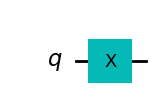

In [14]:
circ_x = QuantumCircuit(1)
circ_x.x(0)
circ_x.draw('mpl')

In [15]:
schedule(circ_x, backend=backend)

Schedule((0, Play(Drag(duration=160, sigma=40, beta=-0.25388969010654494, amp=0.19290084722113582, angle=0.0, name='drag_7346'), DriveChannel(0), name='drag_7346')), name="circuit-90")

In [16]:
drive_amp = Parameter('drive_amp')

with pulse.build(backend = backend, default_alignment = 'sequential', name = 'Rabi Experiment') as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)

    pulse.play(pulse.Gaussian(duration = 160, amp=drive_amp, sigma = 40, name = 'Rabi Pulse'), drive_chan)
    
rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace = False) for a in rabi_points]
    

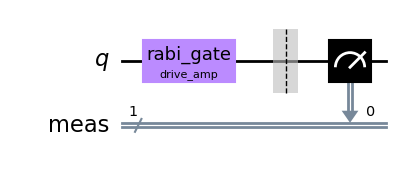

In [17]:
qc = QuantumCircuit(1)
rabi_gate = Gate('rabi_gate', 1, [drive_amp])
qc.append(rabi_gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
qc.measure_all()

qc.draw('mpl')

In [18]:
qc.add_calibration(rabi_gate, [0], rabi_sched)

In [19]:
rabi_circuits = [qc.assign_parameters({drive_amp: a}, inplace = False) for a in rabi_points]

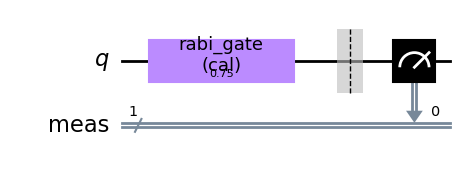

In [20]:
rabi_circuits[-1].draw('mpl')

In [21]:
scheduled_circuits = schedule(rabi_circuits, backend=backend)

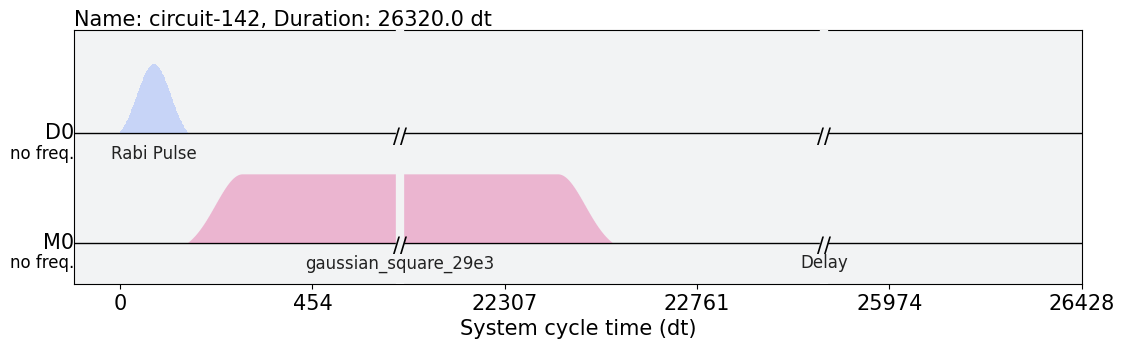

In [22]:
scheduled_circuits[-1].draw()

In [23]:
job = backend.run(scheduled_circuits, shots = 2**12)

In [24]:
results = job.result().get_counts()

C:\Users\pedro\anaconda3\envs\qiskit-39\lib\site-packages\qiskit_aer\pulse\controllers\pulse_controller.py:144: UserWarning: Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, so it is being automatically determined from the drift Hamiltonian.
  warn('Warning: qubit_lo_freq was not specified in PulseQobj and there is no default, '


In [25]:
for entry in results:
    if '0' in entry and entry['0'] == 4096:
        entry['1'] = 0
    elif '1' in entry and entry['1'] == 4096:
        entry['0'] = 1


print(results)

[{'0': 4070, '1': 26}, {'0': 3874, '1': 222}, {'0': 3544, '1': 552}, {'0': 3091, '1': 1005}, {'0': 2550, '1': 1546}, {'0': 1951, '1': 2145}, {'0': 1391, '1': 2705}, {'0': 872, '1': 3224}, {'0': 430, '1': 3666}, {'0': 187, '1': 3909}, {'0': 17, '1': 4079}, {'0': 35, '1': 4061}, {'0': 220, '1': 3876}, {'0': 530, '1': 3566}, {'0': 940, '1': 3156}, {'0': 1481, '1': 2615}, {'0': 2047, '1': 2049}, {'0': 2664, '1': 1432}, {'0': 3125, '1': 971}, {'0': 3614, '1': 482}, {'0': 3916, '1': 180}, {'0': 4079, '1': 17}, {'0': 4080, '1': 16}, {'0': 3932, '1': 164}, {'0': 3591, '1': 505}, {'0': 3148, '1': 948}, {'0': 2596, '1': 1500}, {'0': 2055, '1': 2041}, {'0': 1523, '1': 2573}, {'0': 968, '1': 3128}, {'0': 554, '1': 3542}, {'0': 233, '1': 3863}, {'0': 47, '1': 4049}, {'0': 20, '1': 4076}, {'0': 163, '1': 3933}, {'0': 496, '1': 3600}, {'0': 866, '1': 3230}, {'0': 1282, '1': 2814}, {'0': 1899, '1': 2197}, {'0': 2489, '1': 1607}, {'0': 3016, '1': 1080}, {'0': 3443, '1': 653}, {'0': 3790, '1': 306}, {'0

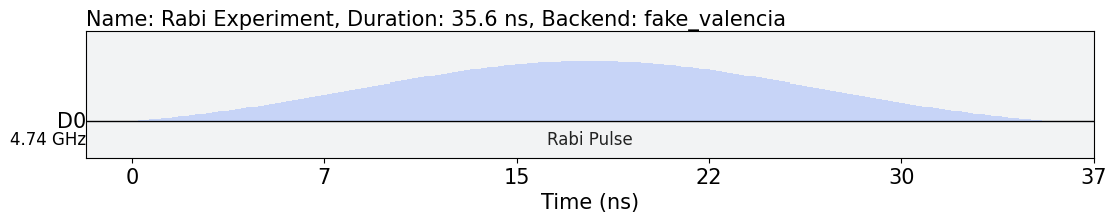

In [26]:
rabi_schedules[-1].draw(backend = backend)

In [27]:
prob_1 = [i['1']/sum(i.values()) for i in results]

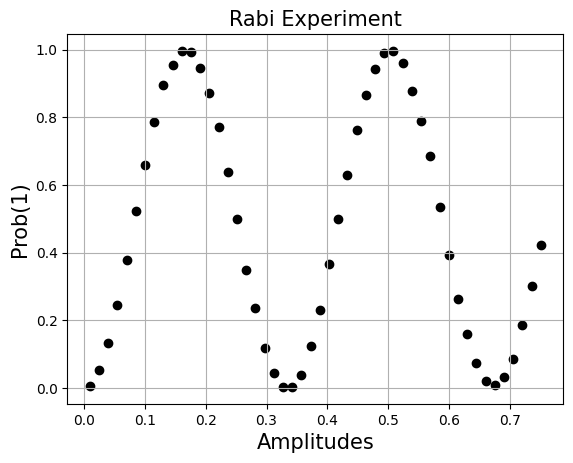

In [28]:


plt.scatter(rabi_points, prob_1, color = 'black') 
plt.title("Rabi Experiment", fontsize=15)
plt.xlabel('Amplitudes', fontsize=15)
plt.ylabel('Prob(1)', fontsize=15)
plt.grid()
plt.show()

In [30]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, initial_parameters):
    fitparams, conv = curve_fit(function, x_values, y_values, initial_parameters)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

The equation which describes the curve shown in the Rabi Oscillations is the following:
$$
\begin{equation}
 Acos(\dfrac{2\pi x}{T} - \phi) + B
\end{equation}
$$

Since the $x-axis$ represents the amplitudes and the $y-axis$ the probability of finding the qubit in $1$, it is clear that the period is the array of amplitudes which takes the qubit from $|0\rangle$ and back to it again. Then it can be said that half of a period will represent the amplitude needed to make the qubit go from $|0\rangle$ to $|1\rangle$. Then $amp = \dfrac{T}{2}$.

In [31]:
fit_param, y_fit = fit_function(rabi_points, prob_1,
                               lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B), [0.5,0.5 ,0.35,np.pi])

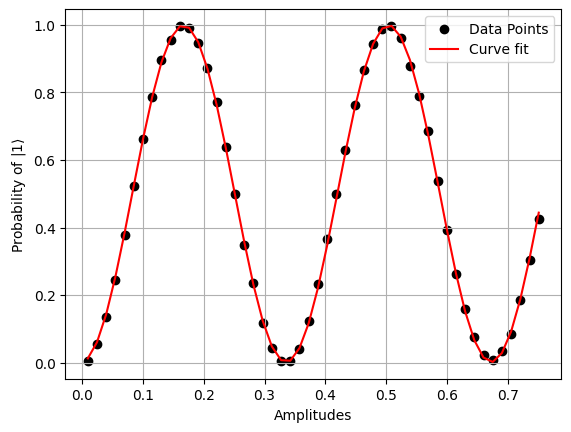

In [32]:
plt.scatter(rabi_points, prob_1, color = 'black', label = 'Data Points') 
plt.plot(rabi_points, y_fit, color= 'red', label = r'Curve fit')
plt.xlabel('Amplitudes')
plt.ylabel(r'Probability of $|1\rangle$')
drive_period = fit_param[2]
plt.grid()
plt.legend()
plt.show()

In [33]:
pi_amp = abs(drive_period/2)
print(f'Pi Amplitude = {pi_amp}')

Pi Amplitude = 0.16828629757059446


Now the $\pi$ pulse can be defined as:

In [34]:
with pulse.build(backend = backend) as pi_pulse:
    drive_chan = pulse.drive_channel(qubit)

    pulse.play(pulse.Gaussian(duration = 160, amp=pi_amp, sigma = 40, name = 'Pi Pulse'), drive_chan)

In [35]:
print(pi_pulse)

ScheduleBlock(Play(Gaussian(duration=160, sigma=40, amp=0.16828629757059446, angle=0, name='Pi Pulse'), DriveChannel(0), name='Pi Pulse'), name="block1", transform=AlignLeft())


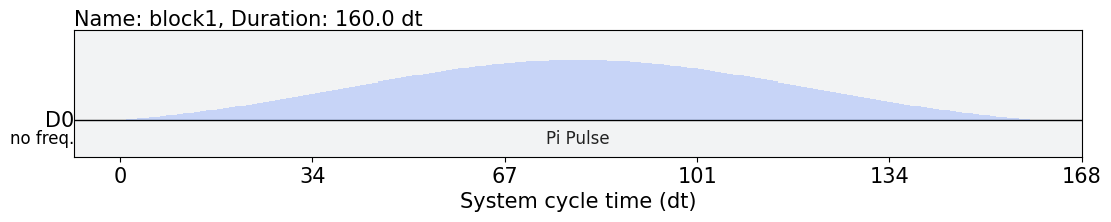

In [36]:
pi_pulse.draw()

### $T_1$ with Pulse

In NMR after a single pulse the collection of nuclear spins will present a certain result magnetization in a plane, according to the pulse given, and they will precess around $B_0$, the magnetic field. However, since there exists external factors the system will decay with time, in an exponential manner, returning to the initial direction of the collection of nuclear spins. This is called longitudinal relatxation.

This happens, however, in any Quantum Computer that is not perfectly isolated from its environment, since interactions between external magnetic fields, temperature and many other factors will influence the Qubit - which in the NMR case is the spin- to relax and return to its ground state. We can visualize and understand this process using the Quantum Computers avaible by IBM, by measuring the T1 relaxation time of simulators and real Quantum Computers. In the following code we will measure T1 of a IBM fake backend simulator, Fake Armonk. 

**How can we measure T1?**

Since T1 is the time constant that describes the process of the qubit decaying from its excited state to its original ground state we can measure it by first preparing the qubit in the excited state, $|1>$, by applying the *NOT* gate, represented by *X*, and waiting some time until measuring the system. This will be repeated  for different wait times and we will notice how the longer we wait, the smaller the probability of finding the qubit in the $|1>$ state will be. 

This probability can be described by an exponential decay given by the formula:

$
\begin{align}
A + Be^{t/T_1}  \text{         }(1)
\end{align}
$

$A$, $B$ and $T_1$ are all constants that will be determined throught the experiment.

In [37]:
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8)%16)

In [38]:
# Delimit time span:
time_max = 450*us
delay_time_secs = np.linspace(1*us, time_max, 200)

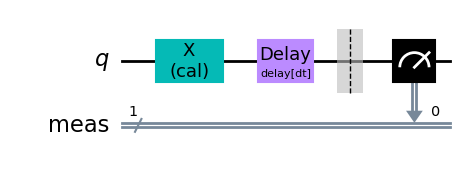

In [40]:
delay = Parameter('delay')
circ_t1 = QuantumCircuit(1)
circ_t1.x(0)
circ_t1.delay(delay,0)
circ_t1.add_calibration("x",[0], pi_pulse)
circ_t1.measure_all()
circ_t1.draw('mpl')

In [41]:
circuits_t1 = [circ_t1.assign_parameters({delay: (int(a/(dt*1e-9)))}, inplace = False) for a in delay_time_secs]
### dt is written should be in ns

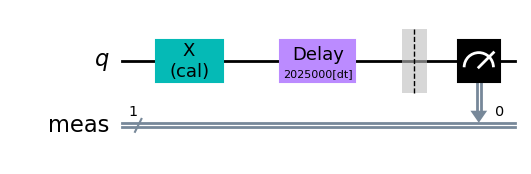

In [42]:
circuits_t1[-1].draw('mpl')

In [43]:
schedule_t1 = schedule(circuits_t1, backend=backend )

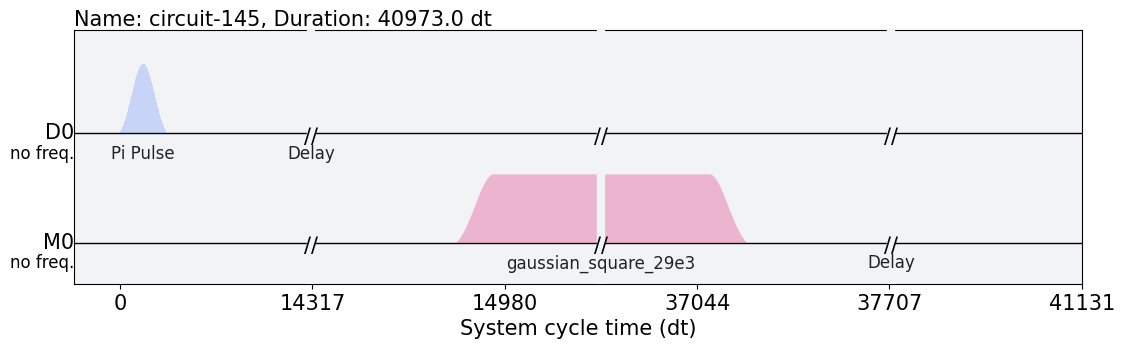

In [44]:
schedule_t1[1].draw()

In [45]:
num_shots = 2**10

job_t1 = backend.run(circuits_t1, shots = num_shots)

In [46]:
t1_res = job_t1.result().get_counts()

In [47]:
prob_1 = [i['1']/sum(i.values()) for i in t1_res]

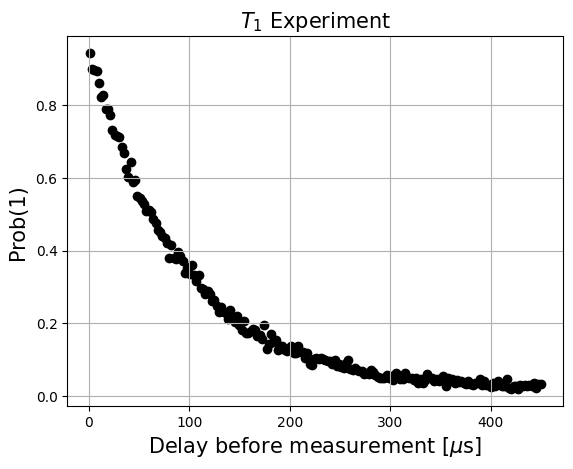

In [48]:
t1_values = []

plt.scatter(delay_time_secs/us, prob_1, c = 'black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(1) ', fontsize=15)
plt.grid()
plt.show()

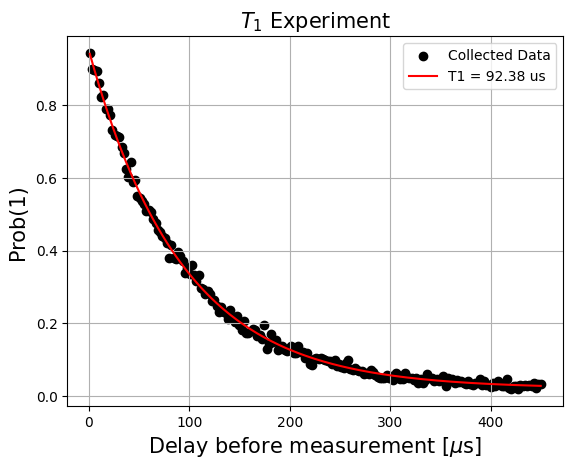

In [49]:
fit_params, y_fit = fit_function(delay_time_secs/us, prob_1, lambda x, A, C, T1: (A*np.exp(-x/T1) + C), [1,0,100])

T1 = fit_params[-1]

plt.scatter(delay_time_secs/us, prob_1, c = 'black', label = 'Collected Data') 
plt.plot(delay_time_secs/us, y_fit, c= 'red', label = f'T1 = {T1:.2f} us')
plt.title(r"$T_1$ Experiment", fontsize=15)
plt.xlabel(r'Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(1) ', fontsize=15)
plt.grid()
plt.legend()
plt.show()

### $T_2$ Experiment using Hahn Echoes:

The $T_2$ time/Transverse relaxation time/Dephasing time characterizes the time where the qubit sufferes a loss of phase. Once again, let's imagine working with a spin qubit. The $T_2$ experiment is started by applying a $\frac{\pi}{2}$ pulse or a Hadamard gate (equivalents), putting the qubit in a state of superposition, ideally represented by ($\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$). We may also represent this in the bloch sphere:

Becase of noise the qubit in question will go through a process of dephasing, where the qubit accumulates a random phase - when thinking with spins the vectors will spread through the ***x-axis*** and the net magnetization will start to get smaller making the spin vector represented in the bloch sphere dissappear with time. The time of this dephasing is measured and characterized as $T_2$. This experiment is done by first applying the $\frac{\pi}{2}$ pulse, applying a delay gate - which get longer throughout the experiment- which will let the qubit dephase and applying a $-\frac{\pi}{2}$ pulse once again, taking the qubit back to the ***z-axis*** where it can be measured. If the qubit has not dephased it will be in $0\rangle$, if it has dephased it will be inbetween $0\rangle$ and $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$. 

In order to find a more intrinsic $T_2$ value we may use a sequence of Hahn Echoes, the first Dynamic Decoupling strategy we will study. In NMR it is used to reduce inhomogeneous effects from the magnetic field. It is done by adding a $\pi$ pulse inbetween the $\frac{\pi}{2}$ pulses, with equal delay times before and after the new pulse. The purpose of this addition is because after the first $\frac{\pi}{2}$ pulse the qubit will start to accumulate a random phase in the ***x-axis***, so once we bring the qubit $180$ degrees to the other side it will start to dephase, canceling out the random phase it had gotten. Once the delay time passed we will apply another $\frac{\pi}{2}$ pulse, bringing the qubit back to the ***z-axis*** where it can be measured. The decay happens in the form: 

$$ 
\begin{equation}
A + Be^{t/T_2} 
\end{equation}
$$

Where we will discover $T_2$ the same way done for $T_1$, by curve fitting the decay curve found.

In [50]:
### First let's define a pi/2 pulse:

pi2_amp = pi_amp/2

with pulse.build(backend) as x90pulse:
    drive_chan = pulse.drive_channel(qubit)

    pulse.play(pulse.Gaussian(duration = 160, amp=pi2_amp, sigma = 40, name = 'pi/2 Pulse'), drive_chan)
    
    

In [51]:
delay_times = np.linspace(1*us, 200*us,50)


In [52]:
qc_t2 = QuantumCircuit(1)

x90gate = Gate('x90gat', 1, [])
pigate = Gate('pigate', 1, [])

qc_t2.h(0)
qc_t2.delay(delay, 0)
qc_t2.x(0)
qc_t2.delay(delay,0)
qc_t2.h(0)

qc_t2.add_calibration('h', [0], x90pulse)
qc_t2.add_calibration('x', [0], pi_pulse)

qc_t2.measure_all()

exp_t2_circuits = [qc_t2.assign_parameters({delay: (int(a/(dt*1e-9)))}, inplace = False) for a in delay_times]

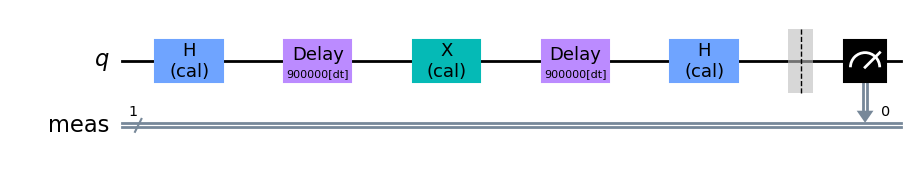

In [53]:
exp_t2_circuits[-1].draw('mpl')

In [54]:
schedule_of_t2 = schedule(exp_t2_circuits[1], backend = backend)

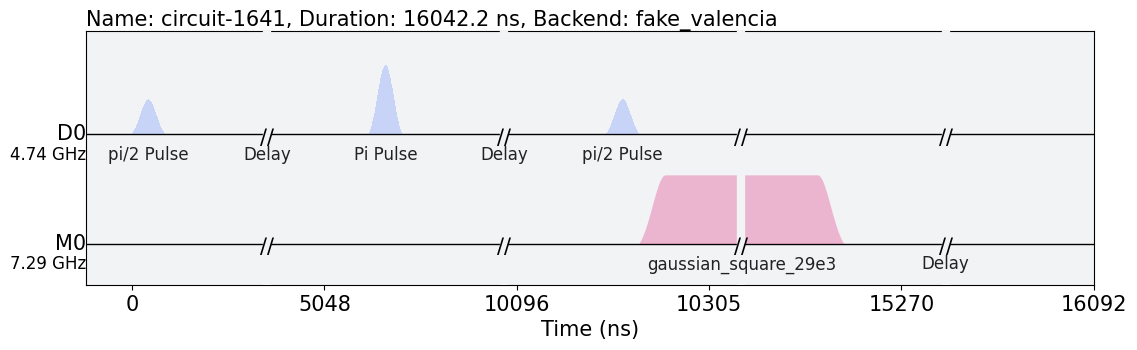

Schedule((0, Play(Gaussian(duration=160, sigma=40, amp=0.08414314878529723, angle=0, name='pi/2 Pulse'), DriveChannel(0), name='pi/2 Pulse')), (160, Delay(22775, DriveChannel(0))), (22935, Play(Gaussian(duration=160, sigma=40, amp=0.16828629757059446, angle=0, name='Pi Pulse'), DriveChannel(0), name='Pi Pulse')), (23095, Delay(22775, DriveChannel(0))), (45870, Play(Gaussian(duration=160, sigma=40, amp=0.08414314878529723, angle=0, name='pi/2 Pulse'), DriveChannel(0), name='pi/2 Pulse')), (46030, Play(GaussianSquare(duration=22400, sigma=64, width=22144, amp=0.075, angle=0.0, name='gaussian_square_29e3'), MeasureChannel(0), name='gaussian_square_29e3')), (46030, Acquire(26160, AcquireChannel(0), MemorySlot(0))), (68430, Delay(3760, MeasureChannel(0))), name="circuit-1641")


In [72]:
display(schedule_of_t2.draw(backend=backend))
print(schedule_of_t2)

In [56]:
exp_t2_circuits = [qc_t2.assign_parameters({delay: (int(a/(dt*1e-9)))}, inplace = False) for a in delay_times]

In [57]:
num_shots_per_point = 2**9

job = backend.run(exp_t2_circuits,
               shots = num_shots)



In [58]:
t2_result = job.result(timeout = 500)

In [59]:
t2counts = t2_result.get_counts()

In [64]:
prob_0 = [i['0']/sum(i.values()) for i in t2counts]

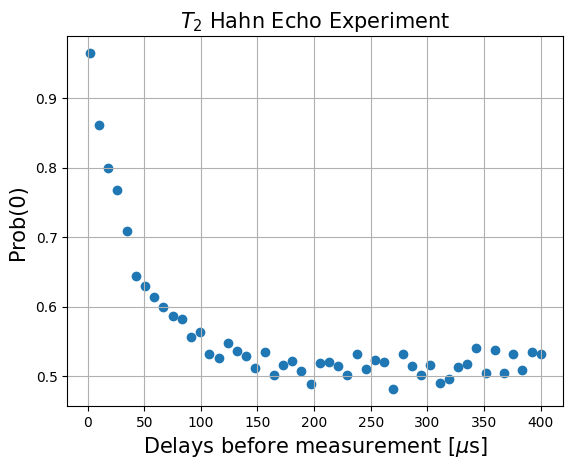

In [69]:
plt.scatter(2*delay_times/us, prob_0) 
plt.title("$T_2$ Hahn Echo Experiment", fontsize=15)
plt.xlabel('Delays before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(0) ', fontsize=15)
plt.grid()
plt.show()

38.15975820248084


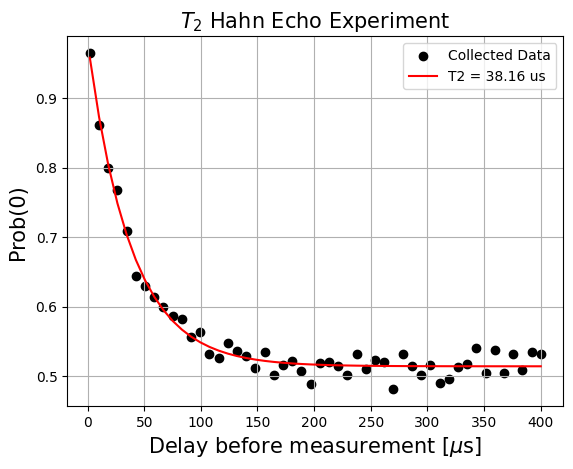

In [70]:
fit_params, y_fit = fit_function(2*delay_times/us, prob_0,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

T2 = fit_params[-1]
print(T2)

plt.scatter(2*delay_times/us, prob_0, c = 'black', label = 'Collected Data') 
plt.plot(2*delay_times/us, y_fit, c= 'red', label = f'T2 = {T2:.2f} us')
plt.title(r"$T_2$ Hahn Echo Experiment", fontsize=15)
plt.xlabel(r'Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Prob(0) ', fontsize=15)
plt.grid()
plt.legend()
plt.show()

All simulations appear to run smoothly. We were able to create the $\pi$ pulse and with it run two important experiments. To further show that this routines work this process will be repeated using a real quantum computer and the values for $T_1$ and $T_2$ will be calculated and compared with their measured values.